# Video Classification with Transformers
**Description:** Training a video classifier with hybrid transformers.

In [1]:
!pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done


## Data collection

We will be using a subsampled version of the
[UCF101 dataset](https://www.crcv.ucf.edu/data/UCF101.php),
a well-known benchmark dataset.

In [2]:
!wget -q https://github.com/sayakpaul/Action-Recognition-in-TensorFlow/releases/download/v1.0.0/ucf101_top5.tar.gz
!tar -xf ucf101_top5.tar.gz

## Setup

In [3]:
import os
import keras
from keras import layers
from keras.applications.densenet import DenseNet121

from tensorflow_docs.vis import embed

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import imageio
import cv2

## Define hyperparameters

In [4]:
MAX_SEQ_LENGTH = 20
NUM_FEATURES = 1024
IMG_SIZE = 128

EPOCHS = 5

## Data preparation

* We reduce the image size to 128x128 instead of 224x224 to speed up computation.
* Instead of using a pre-trained [InceptionV3](https://arxiv.org/abs/1512.00567) network,
we use a pre-trained
[DenseNet121](http://openaccess.thecvf.com/content_cvpr_2017/papers/Huang_Densely_Connected_Convolutional_CVPR_2017_paper.pdf)
for feature extraction.
* We directly pad shorter videos to length `MAX_SEQ_LENGTH`.

First, let's load up the
[DataFrames](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html).

In [5]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

center_crop_layer = layers.CenterCrop(IMG_SIZE, IMG_SIZE)


def crop_center(frame):
    cropped = center_crop_layer(frame[None, ...])
    cropped = keras.ops.convert_to_numpy(cropped)
    cropped = keras.ops.squeeze(cropped)
    return cropped


# Following method is modified from this tutorial:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
def load_video(path, max_frames=0, offload_to_cpu=False):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = frame[:, :, [2, 1, 0]]
            frame = crop_center(frame)
            if offload_to_cpu and keras.backend.backend() == "torch":
                frame = frame.to("cpu")
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    if offload_to_cpu and keras.backend.backend() == "torch":
        return np.array([frame.to("cpu").numpy() for frame in frames])
    return np.array(frames)


def build_feature_extractor():
    feature_extractor = DenseNet121(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.densenet.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()


# Label preprocessing with StringLookup.
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["tag"]), mask_token=None
)
print(label_processor.get_vocabulary())


def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()
    labels = df["tag"].values
    labels = label_processor(labels[..., None]).numpy()

    # `frame_features` are what we will feed to our sequence model.
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path))

        # Pad shorter videos.
        if len(frames) < MAX_SEQ_LENGTH:
            diff = MAX_SEQ_LENGTH - len(frames)
            padding = np.zeros((diff, IMG_SIZE, IMG_SIZE, 3))
            frames = np.concatenate(frames, padding)

        frames = frames[None, ...]

        # Initialize placeholder to store the features of the current video.
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                if np.mean(batch[j, :]) > 0.0:
                    temp_frame_features[i, j, :] = feature_extractor.predict(
                        batch[None, j, :]
                    )

                else:
                    temp_frame_features[i, j, :] = 0.0

        frame_features[idx,] = temp_frame_features.squeeze()

    return frame_features, labels


Total videos for training: 594
Total videos for testing: 224
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
['CricketShot', 'PlayingCello', 'Punch', 'ShavingBeard', 'TennisSwing']


Calling `prepare_all_videos()` on `train_df` and `test_df` takes ~20 minutes to
complete. For this reason, to save time, here we download already preprocessed NumPy arrays:

In [6]:
!!wget -q https://git.io/JZmf4 -O top5_data_prepared.tar.gz
!!tar -xf top5_data_prepared.tar.gz

[]

In [7]:
train_data, train_labels = np.load("train_data.npy"), np.load("train_labels.npy")
test_data, test_labels = np.load("test_data.npy"), np.load("test_labels.npy")

print(f"Frame features in train set: {train_data.shape}")

Frame features in train set: (594, 20, 1024)


## Building the Transformer-based model

We will be building on top of the code shared in
[this book chapter](https://livebook.manning.com/book/deep-learning-with-python-second-edition/chapter-11) of
[Deep Learning with Python (Second ed.)](https://www.manning.com/books/deep-learning-with-python)
by François Chollet.

First, self-attention layers that form the basic blocks of a Transformer are
order-agnostic. Since videos are ordered sequences of frames, we need our
Transformer model to take into account order information.
We do this via **positional encoding**.
We simply embed the positions of the frames present inside videos with an
[`Embedding` layer](https://keras.io/api/layers/core_layers/embedding). We then
add these positional embeddings to the precomputed CNN feature maps.

In [8]:

class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim
        )
        self.sequence_length = sequence_length
        self.output_dim = output_dim

    def build(self, input_shape):
        self.position_embeddings.build(input_shape)

    def call(self, inputs):
        # The inputs are of shape: `(batch_size, frames, num_features)`
        inputs = keras.ops.cast(inputs, self.compute_dtype)
        length = keras.ops.shape(inputs)[1]
        positions = keras.ops.arange(start=0, stop=length, step=1)
        embedded_positions = self.position_embeddings(positions)
        return inputs + embedded_positions


Now, we can create a subclassed layer for the Transformer.

In [9]:

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.3
        )
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(dense_dim, activation=keras.activations.gelu),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)


## Utility functions for training

In [10]:

def get_compiled_model(shape):
    sequence_length = MAX_SEQ_LENGTH
    embed_dim = NUM_FEATURES
    dense_dim = 4
    num_heads = 1
    classes = len(label_processor.get_vocabulary())

    inputs = keras.Input(shape=shape)
    x = PositionalEmbedding(
        sequence_length, embed_dim, name="frame_position_embedding"
    )(inputs)
    x = TransformerEncoder(embed_dim, dense_dim, num_heads, name="transformer_layer")(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs)

    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


def run_experiment():
    filepath = "/tmp/video_classifier.weights.h5"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    model = get_compiled_model(train_data.shape[1:])
    history = model.fit(
        train_data,
        train_labels,
        validation_split=0.15,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    model.load_weights(filepath)
    _, accuracy = model.evaluate(test_data, test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return model


## Model training and inference

In [11]:
trained_model = run_experiment()

Epoch 1/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.5138 - loss: 2.5925
Epoch 1: val_loss improved from inf to 0.46160, saving model to /tmp/video_classifier.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 547ms/step - accuracy: 0.5251 - loss: 2.5283 - val_accuracy: 0.7556 - val_loss: 0.4616
Epoch 2/5
 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9567 - loss: 0.1641 
Epoch 2: val_loss did not improve from 0.46160
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9557 - loss: 0.1646 - val_accuracy: 0.2111 - val_loss: 3.4248
Epoch 3/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9753 - loss: 0.0620
Epoch 3: val_loss did not improve from 0.46160
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9752 - loss: 0.0618 - val_accuracy: 0.7889 - val_loss: 0.8574
Epoch 4/5
 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9928 - loss: 0.0112  
Epoch 4: val_loss did not improve from 0.46160
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9926 - loss: 0.0120 - 

Test video path: v_ShavingBeard_g07_c06.avi
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 921ms/step
  ShavingBeard: 99.99%
  PlayingCello:  0.01%
  Punch:  0.00%
  TennisSwing:  0.00%
  CricketShot:  0.00%


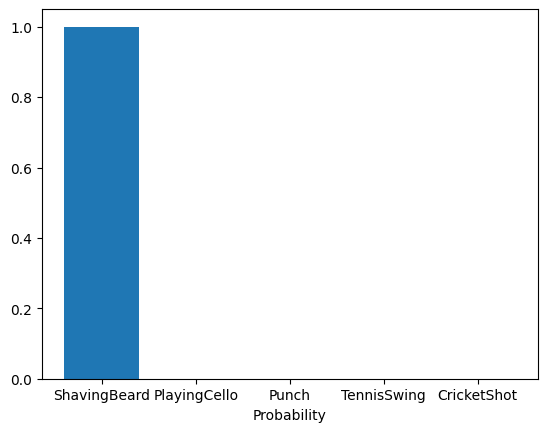


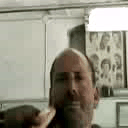

In [12]:

def prepare_single_video(frames):
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    # Pad shorter videos.
    if len(frames) < MAX_SEQ_LENGTH:
        diff = MAX_SEQ_LENGTH - len(frames)
        padding = np.zeros((diff, IMG_SIZE, IMG_SIZE, 3))
        frames = np.concatenate(frames, padding)

    frames = frames[None, ...]

    # Extract features from the frames of the current video.
    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            if np.mean(batch[j, :]) > 0.0:
                frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
            else:
                frame_features[i, j, :] = 0.0

    return frame_features


def predict_action(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(os.path.join("test", path), offload_to_cpu=True)
    frame_features = prepare_single_video(frames)
    probabilities = trained_model.predict(frame_features)[0]

    plot_x_axis, plot_y_axis = [], []

    for i in np.argsort(probabilities)[::-1]:
        plot_x_axis.append(class_vocab[i])
        plot_y_axis.append(probabilities[i])
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")

    plt.bar(plot_x_axis, plot_y_axis, label=plot_x_axis)
    plt.xlabel("class_label")
    plt.xlabel("Probability")
    plt.show()

    return frames

def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")


test_video = np.random.choice(test_df["video_name"].values.tolist())
print(f"Test video path: {test_video}")
test_frames = predict_action(test_video)
to_gif(test_frames[:MAX_SEQ_LENGTH])

The performance of our model is far from optimal, because it was trained on a
small dataset.

In [13]:
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# Step 1: Define the Student GRU Model
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])  # Use the last GRU output
        return out

# Step 2: Define the Dataset Class
class DistillationDataset(Dataset):
    def __init__(self, data, labels, teacher_probs):
        """
        Args:
            data: Numpy array or Tensor of features.
            labels: Ground truth labels.
            teacher_probs: Soft probabilities from the teacher model.
        """
        self.data = data
        self.labels = labels
        self.teacher_probs = teacher_probs

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.data[idx], dtype=torch.float32),
            torch.tensor(self.labels[idx], dtype=torch.long),
            torch.tensor(self.teacher_probs[idx], dtype=torch.float32),
        )

# Step 3: Distillation Loss
def distillation_loss(student_logits, teacher_probs, labels, alpha=0.5, temperature=2.0):
    """
    Args:
        student_logits: Logits from the student model.
        teacher_probs: Soft probabilities from the teacher model.
        labels: Ground truth labels.
        alpha: Weight for balancing hard loss (ground truth) and soft loss (teacher).
        temperature: Temperature for softening probabilities.
    """
    soft_loss = nn.KLDivLoss(reduction="batchmean")(
        nn.functional.log_softmax(student_logits / temperature, dim=1),
        nn.functional.softmax(teacher_probs / temperature, dim=1),
    ) * (temperature ** 2)
    hard_loss = nn.CrossEntropyLoss()(student_logits, labels)
    return alpha * hard_loss + (1 - alpha) * soft_loss

# Step 4: Knowledge Distillation Training
def train_student(teacher_model, train_data, train_labels, test_data, test_labels):
    # Get teacher predictions
    teacher_probs = teacher_model.predict(train_data)

    # Create Dataset and DataLoader
    train_dataset = DistillationDataset(train_data, train_labels, teacher_probs)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    # Define the Student Model
    input_size = train_data.shape[-1]
    hidden_size = 128
    output_size = 5  # Number of classes
    student_model = GRUModel(input_size, hidden_size, output_size)
    student_model = student_model.to("cuda" if torch.cuda.is_available() else "cpu")

    # Optimizer and Scheduler
    optimizer = optim.Adam(student_model.parameters(), lr=0.001)

    # Training Loop
    epochs = 10
    for epoch in range(epochs):
        student_model.train()
        epoch_loss = 0
        for data, labels, teacher_probs in train_loader:
            data, labels, teacher_probs = (
                data.to("cuda"),
                labels.to("cuda"),
                teacher_probs.to("cuda"),
            )

            optimizer.zero_grad()
            student_logits = student_model(data)
            loss = distillation_loss(student_logits, teacher_probs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}")

    # Evaluate on test data
    student_model.eval()
    test_data = torch.tensor(test_data, dtype=torch.float32).to("cuda")
    test_labels = torch.tensor(test_labels, dtype=torch.long).to("cuda")
    with torch.no_grad():
        predictions = student_model(test_data).argmax(dim=1)
        accuracy = (predictions == test_labels).float().mean()
    print(f"Student Model Test Accuracy: {accuracy:.4f}")

    return student_model

# Step 5: Train and Distill
# Assuming `trained_model` is your Transformer teacher
# Fix labels format before passing to the function
train_labels = torch.tensor(train_labels, dtype=torch.long).squeeze()
test_labels = torch.tensor(test_labels, dtype=torch.long).squeeze()

# Train and distill
student_model = train_student(trained_model, train_data, train_labels, test_data, test_labels)

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step


<ipython-input-13-044b0bacdcd1>:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.labels[idx], dtype=torch.long),


Epoch 1/10, Loss: 9.9549
Epoch 2/10, Loss: 6.1377
Epoch 3/10, Loss: 5.6827
Epoch 4/10, Loss: 5.5056
Epoch 5/10, Loss: 5.4280
Epoch 6/10, Loss: 5.3870
Epoch 7/10, Loss: 5.3641
Epoch 8/10, Loss: 5.3432
Epoch 9/10, Loss: 5.3347
Epoch 10/10, Loss: 5.3248
Student Model Test Accuracy: 0.9464


<ipython-input-13-044b0bacdcd1>:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_labels = torch.tensor(test_labels, dtype=torch.long).to("cuda")


In [16]:
# Save the GRU model
model_path = "student_gru_model.pth"
torch.save(student_model.state_dict(), model_path)
print(f"Model saved to {model_path}")


Model saved to student_gru_model.pth


In [17]:
# Initialize the GRU model with the same architecture
input_size = train_data.shape[-1]
hidden_size = 128
output_size = 5  # Number of classes

loaded_student_model = GRUModel(input_size, hidden_size, output_size)
loaded_student_model.load_state_dict(torch.load(model_path))
loaded_student_model = loaded_student_model.to("cuda" if torch.cuda.is_available() else "cpu")
loaded_student_model.eval()  # Set to evaluation mode
print("Model loaded successfully!")


Model loaded successfully!


<ipython-input-17-9990e6ca937d>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_student_model.load_state_dict(torch.load(model_path))


In [ ]:
print(input_size)

1024


In [18]:
# Evaluate the model on test data
test_data_tensor = torch.tensor(test_data, dtype=torch.float32).to("cuda")
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long).to("cuda")

# Forward pass to get predictions
with torch.no_grad():
    test_predictions = student_model(test_data_tensor).argmax(dim=1)
    test_accuracy = (test_predictions == test_labels_tensor).float().mean()

print(f"Test Accuracy: {test_accuracy.item() * 100:.2f}%")

Test Accuracy: 94.64%


<ipython-input-18-78574a9459dc>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_labels_tensor = torch.tensor(test_labels, dtype=torch.long).to("cuda")


# Part-2 Distillation

In [19]:
import torch
import os

# Federated Averaging Function
def federated_averaging(student_model, global_model, global_model_path="global_model.pth"):
    """
    Performs selective layer aggregation between the student and global models.
    Args:
        student_model: The trained student model.
        global_model: The global GRU model.
        global_model_path: Path to the saved global model file.
    """
    # Check if the global model file exists
    if not os.path.exists(global_model_path):
        print("Global model not found. Initializing and saving a new global model.")
        torch.save(global_model.state_dict(), global_model_path)

    # Load the global model state
    global_model.load_state_dict(torch.load(global_model_path))

    # Perform Federated Averaging for common layers
    with torch.no_grad():
        for global_param, student_param in zip(global_model.parameters(), student_model.parameters()):
            # Skip the extra layer in the global model
            if global_param.shape != student_param.shape:
                print(f"Skipping layer with shape {global_param.shape} (not in student model).")
                continue
            # Average the weights
            global_param.data.copy_((global_param.data + student_param.data) / 2)

    # Save the updated global model
    torch.save(global_model.state_dict(), global_model_path)
    print(f"Global model updated and saved at {global_model_path}.")


In [20]:
# Define the global GRU model (with extra layer)
class GlobalGRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, extra_layer_dim=1):
        super(GlobalGRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.extra_layer = nn.Linear(hidden_size, extra_layer_dim)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])
        extra_out = self.extra_layer(out)
        return out, extra_out

# Initialize global and student models
input_size = 1024
hidden_size = 128
output_size = 5

global_model = GlobalGRUModel(input_size, hidden_size, output_size, extra_layer_dim=1).to("cuda")

# Perform Federated Averaging
federated_averaging(student_model, global_model, global_model_path="global_model.pth")


Global model not found. Initializing and saving a new global model.
Global model updated and saved at global_model.pth.


<ipython-input-19-44d1f2490e09>:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  global_model.load_state_dict(torch.load(global_model_path))


In [21]:
import torch
import torch.nn as nn

# Define the Global GRU Model (same architecture as used in training)
class GlobalGRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GlobalGRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.extra_layer = nn.Linear(hidden_size, 1)  # Used for anomaly detection, not updated for video classification

    def forward(self, x, get_logits=False):
        out, _ = self.gru(x)
        last_hidden = out[:, -1, :]  # Last hidden state
        logits = self.fc(last_hidden)
        if get_logits:
            return last_hidden  # Return logits before the final classification layer
        return logits

# Load the saved global model
global_model_path = "global_model.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the model
input_size = 1024  # Adjust according to your test data features
hidden_size = 128  # Same as the trained model
output_size = 5    # Number of classes
global_model = GlobalGRUModel(input_size, hidden_size, output_size).to(device)
global_model.load_state_dict(torch.load(global_model_path, map_location=device))
global_model.eval()

# Testing
with torch.no_grad():
    # Get logits from the last-but-one layer
    logits_before_final = global_model(test_data_tensor, get_logits=True)

    # Get final predictions
    predictions = global_model(test_data_tensor).argmax(dim=1)

    # Calculate accuracy
    accuracy = (predictions == test_labels_tensor).float().mean().item()

print("Logits from last-but-one layer:", logits_before_final.shape)
print("Test Accuracy:", accuracy)


Logits from last-but-one layer: torch.Size([224, 128])
Test Accuracy: 0.8705357313156128


<ipython-input-21-2448ba8c55e2>:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  global_model.load_state_dict(torch.load(global_model_path, map_location=device))
